In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
st = set(stopwords.words('english'))

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/NewUser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/NewUser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
# read in data
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')

# basic cuts on targets
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 60].index]
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.25].index]
df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 10].index]

df_eng.reset_index(drop=True, inplace=True)

In [145]:
df_eng['bio_count'] = df_eng['bio'].apply(lambda x: len(str(x).split(" ")))
df_eng[['bio','bio_count']].head()

,bio,bio_count
0,"Hey all! I'm Alex, a full stack software engin...",174
1,The school year's in full swing! Feel free to ...,290
2,"Hello, I grew up mostly in New York City and w...",354
3,I came to tutoring as a second career after re...,194
4,Hello! My name is Jonah S.-Z. I live in the be...,286


In [148]:
freq = pd.Series(' '.join(df_eng['bio']).split()).value_counts()[:20]
freq

and         22156
I           20546
to          15453
the         13335
a           12506
in          12273
of           9491
have         6908
my           5907
with         5840
for          5750
students     5227
as           4403
is           3808
that         3734
am           3338
you          3060
at           3029
math         2941
tutoring     2733
dtype: int64

In [157]:
%%time
#Create the corpus of bios

stop_words = set(stopwords.words("english"))
new_words = ["using", "show", "result", "large", "also", "one", "two", "new", "previously", "shown", 'math']
stop_words = stop_words.union(new_words)

corpus = []
for i in range(0, len(df_eng['bio'])):
    
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df_eng['bio'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # remove periods
    text = text.replace('.', '').replace(',' , '')
    
    #Convert to list from string
    text = text.split()
    
    ##Stemming
    stemmer=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    corpus.append(text)

CPU times: user 2.94 s, sys: 8.07 ms, total: 2.95 s
Wall time: 2.95 s


[Text(0, 0, 'student'),
 Text(0, 0, 'school'),
 Text(0, 0, 'tutoring'),
 Text(0, 0, 'year'),
 Text(0, 0, 'help'),
 Text(0, 0, 'teaching'),
 Text(0, 0, 'college'),
 Text(0, 0, 'high'),
 Text(0, 0, 'experience'),
 Text(0, 0, 'tutor'),
 Text(0, 0, 'science'),
 Text(0, 0, 'subject'),
 Text(0, 0, 'algebra'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'university'),
 Text(0, 0, 'mathematics'),
 Text(0, 0, 'work'),
 Text(0, 0, 'level'),
 Text(0, 0, 'calculus'),
 Text(0, 0, 'time')]

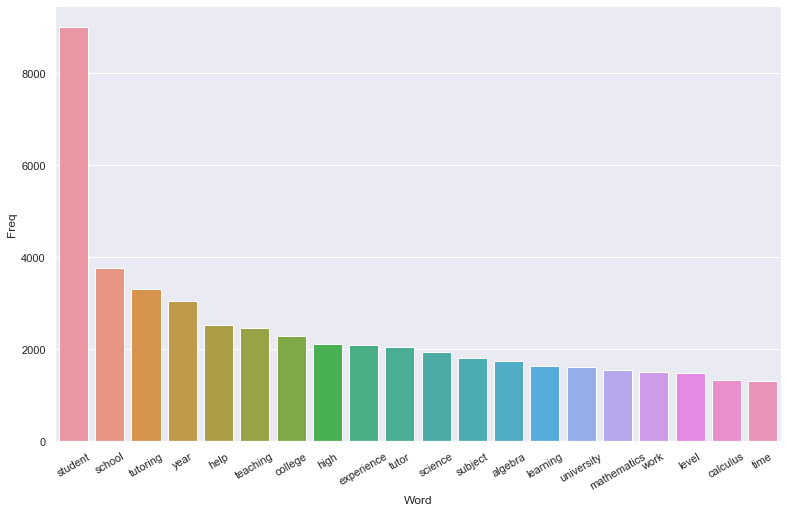

In [158]:
#Most frequently occuring words

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'high school'),
 Text(0, 0, 'help student'),
 Text(0, 0, 'middle school'),
 Text(0, 0, 'helping student'),
 Text(0, 0, 'look forward'),
 Text(0, 0, 'year experience'),
 Text(0, 0, 'school college'),
 Text(0, 0, 'school student'),
 Text(0, 0, 'sat act'),
 Text(0, 0, 'algebra algebra'),
 Text(0, 0, 'algebra geometry'),
 Text(0, 0, 'master degree'),
 Text(0, 0, 'college level'),
 Text(0, 0, 'computer science'),
 Text(0, 0, 'experience tutoring'),
 Text(0, 0, 'working student'),
 Text(0, 0, 'tutoring experience'),
 Text(0, 0, 'college student'),
 Text(0, 0, 'feel free'),
 Text(0, 0, 'learning style')]

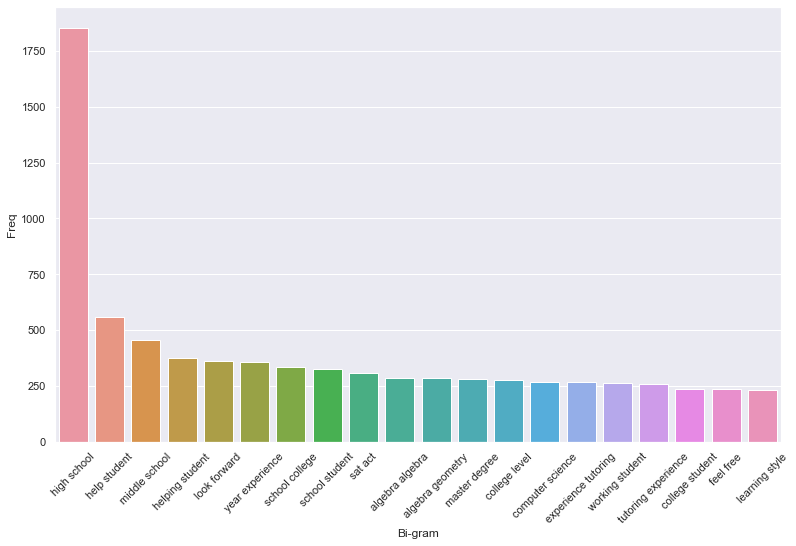

In [159]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

[Text(0, 0, 'high school colleg'),
 Text(0, 0, 'high school student'),
 Text(0, 0, 'feel free contact'),
 Text(0, 0, 'pre algebra algebra'),
 Text(0, 0, 'middl high school'),
 Text(0, 0, 'school high school'),
 Text(0, 0, 'tutor high school'),
 Text(0, 0, 'look forward work'),
 Text(0, 0, 'middl school high'),
 Text(0, 0, 'pleas feel free'),
 Text(0, 0, 'year experi tutor'),
 Text(0, 0, 'look forward hear'),
 Text(0, 0, 'high school level'),
 Text(0, 0, 'help student understand'),
 Text(0, 0, 'year tutor experi'),
 Text(0, 0, 'algebra geometri trigonometri'),
 Text(0, 0, 'help student learn'),
 Text(0, 0, 'school colleg level'),
 Text(0, 0, 'algebra algebra geometri'),
 Text(0, 0, 'year experi teach')]

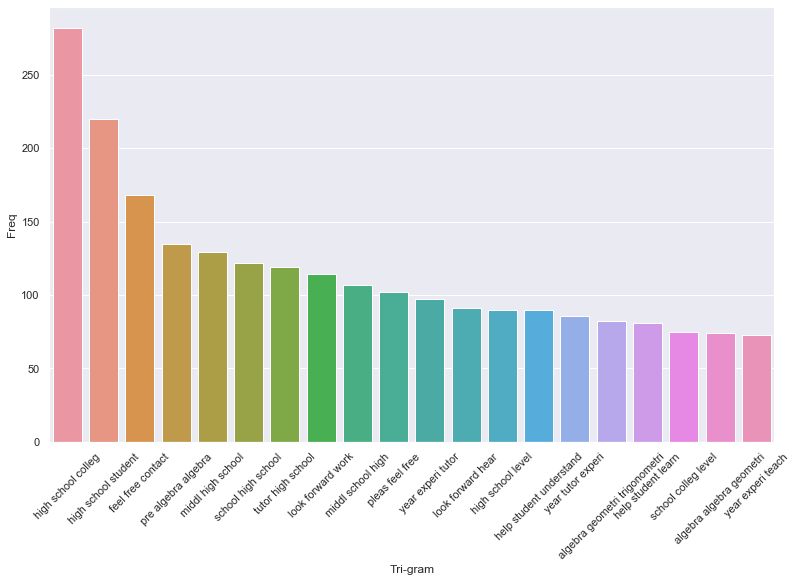

In [156]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [164]:
%%time

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
vectors = vectorizer.fit(corpus)
vectors = vectors.transform(corpus)

names = vectorizer.get_feature_names()
data = vectors.todense().tolist()
# Create a dataframe with the results
df_nlp = pd.DataFrame(data, columns=names)

CPU times: user 4.57 s, sys: 207 ms, total: 4.77 s
Wall time: 4.78 s


In [188]:
df_nlp

,ab,ability,able,able help,academic,academy,accounting,achieve,achieve goal,across,...,year experience tutoring,year old,year taught,year teaching,year tutored,year tutoring,year tutoring experience,york,young,younger
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.086372,0.128150,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
1,0.0,0.075208,0.068125,0.000000,0.071568,0.0,0.000000,0.156221,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.077586,0.0,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.087844,0.000000,0.00000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.060789,0.090193,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
2102,0.0,0.000000,0.000000,0.000000,0.212761,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.083876,0.06741,0.0,0.000000,0.0,0.000000
2103,0.0,0.000000,0.063472,0.101733,0.000000,0.0,0.214479,0.145553,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
2104,0.0,0.000000,0.184055,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.156017
